# Portfolio Choice 2

This notebook solves a portfolio optimization problem with several risky assets. The objective function of the investor trades off the portfolio expected return and variance. There are no restrictions on the portfolio weights, except that they must sum to 1 (across all assets, risky and riskfree).

## Load Packages and Extra Functions

In [1]:
using Printf, LinearAlgebra

include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))            #pyplot() or gr()
gr(size=(480,320))
default(fmt = :png)

# From Chapter on Mean-Variance Analysis

The file included below contains functions from the chapter on MV analysis.

In [3]:
include("jlFiles/MvCalculations.jl")

MVTangencyP

# Optimal Portfolio Choice

An investor who maximizes

$\text{E}U(R_{p})   =\text{E}R_{p}-\frac{k}{2} \text{Var}(R_{p})$,

subject to 

$R_{p} = v'R^e + R_f$

will pick the portfolio weights (on the risky assets)

$v  =\frac{1}{k}\Sigma^{-1}\mu^{e}$

The portfolio weight on the riskfree asset is $1-\mathbf{1}'v$

In [4]:
"""
Calculate optimal portfolio weights
"""
function OptimalPortfolio(μ,Σ,Rf,k)
    μᵉ    = μ .- Rf             #expected excess returns
    v     = inv(Σ) * μᵉ/k       #optimal weights risky assets, 1-sum(v) in riskfree
    ERp   = v'μ + (1-sum(v))*Rf #expected return and std of optimal portfolio
    StdRp = sqrt(v'Σ*v)
    return v,ERp,StdRp
end 

OptimalPortfolio

## An Example with 2 Risky Assets and a Riskfree Asset

We first solve an example with 2 risky assets and a riskfree asset. In this case, we can plot how the objective function depends on the portfolio weights.

In [5]:
μ = [8.5, 6.5]/100                     #means
Σ = [166  34;                          #covariance matrix 
      34  64]/100^2
Rf = 3/100;                            #riskfree rate

In [6]:
k = 9

(n₁,n₂)  = (21,23)
v₁_range = range(-0.5,1.5,length=n₁)    #portfolio weights asset 1
v₂_range = range(-0.5,1.5,length=n₂)    # ""                     2 

Util = fill(NaN,(n₁,n₂))
for i = 1:n₁, j = 1:n₂         #loop across portfolio weights
    #local v                   #local/global is needed in script
    v         = [v₁_range[i];v₂_range[j]]
    Util[i,j] = v'μ + (1-sum(v))*Rf - (k/2)*v'Σ*v
end

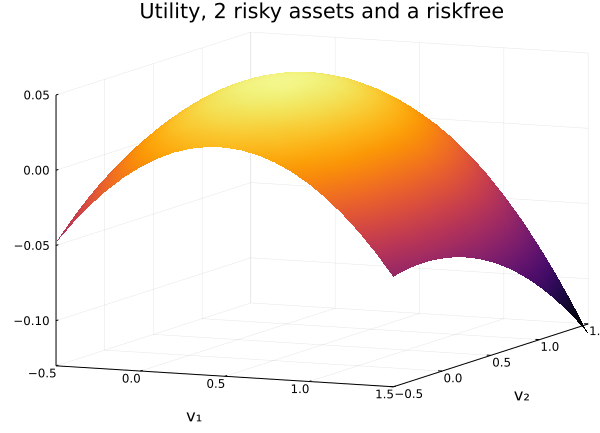

In [7]:
p1 = surface( v₁_range,v₂_range,Util',
              size = (600,433),
              legend = false,
              xlims = (-0.5,1.5),
              ylims = (-0.5,1.5),
              zlims = (-0.13,0.05),
              xlabel = "v₁",
              ylabel = "v₂",
              title = "Utility, 2 risky assets and a riskfree" )
display(p1)

The next cell calls on `OptimalPortfolio()` to calculate the optimal weights - and also compares with the tangency portfolio.

In [8]:
vOpt, = OptimalPortfolio(μ,Σ,Rf,k)         #find optimal portfolio

assetNames = ["Asset 1","Asset 2","Riskfree"]

printblue("optimal portfolio weights on risky assets and riskfree when k = $k:")
printmat([vOpt;(1-sum(vOpt))],rowNames=assetNames)

printblue("optimal portfolio weights on risky assets/their sum:")
printmat(vOpt/sum(vOpt),rowNames=assetNames)

wT, = MVTangencyP(μ,Σ,Rf)
printblue("Tangency portfolio:")
printmat(wT,rowNames=assetNames)

optimal portfolio weights on risky assets and riskfree when k = 9:
Asset 1      0.273
Asset 2      0.462
Riskfree     0.264

optimal portfolio weights on risky assets/their sum:
Asset 1      0.372
Asset 2      0.628

Tangency portfolio:
Asset 1      0.372
Asset 2      0.628



## An Example with 3 Risky Assets  (and a Riskfree)

We now apply the same approach on more assets - and compare the optimal portfolios for different investors (with different risk aversions).

We then show where the optimal portfolios are in plot of the mean-variance frontier.

In [9]:
μ = [11.5, 9.5, 6]/100
Σ = [166  34  58;
      34  64   4;
      58   4 100]/100^2
Rf = 0.03;

In [10]:
(vD,muD,StdD) = OptimalPortfolio(μ,Σ,Rf,28)        #high risk aversion
(vE,muE,StdE) = OptimalPortfolio(μ,Σ,Rf,8.8)       #low risk aversion

(wT,muT,StdT) = MVTangencyP(μ,Σ,Rf)                #tangency portfolio

assetNames = ["Asset A","Asset B","Asset C","Riskfree"]

printblue("optimal portfolio weights:")
xx = hcat([vD;(1-sum(vD))],[vE;(1-sum(vE))])
printmat(xx,colNames=["D","E"],rowNames=assetNames)

printblue("optimal weights/tangency portfolio:")
xx = [vD vE]./wT
printmat(xx,colNames=["D","E"],rowNames=assetNames)

optimal portfolio weights:
                 D         E
Asset A      0.110     0.350
Asset B      0.302     0.962
Asset C      0.031     0.099
Riskfree     0.556    -0.411

optimal weights/tangency portfolio:
                 D         E
Asset A      0.444     1.411
Asset B      0.444     1.411
Asset C      0.444     1.411



In [11]:
L = 101
μstar_range = range(Rf,0.15,length=L)

StdRp = fill(NaN,(L,2))                 #loop over required average returns (μstar)
for i = 1:L
    StdRp[i,1] = MVCalc(μstar_range[i],μ,Σ)[1]           #risky only
    StdRp[i,2] = MVCalcRf(μstar_range[i],μ,Σ,Rf)[1]      #risky and riskfree
end

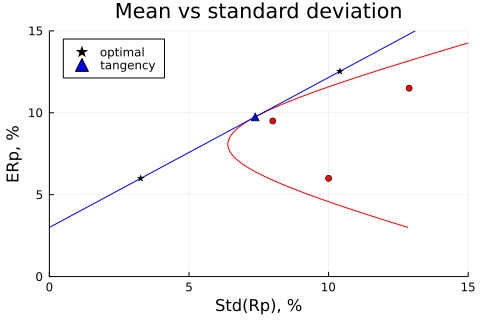

In [12]:
p1 = plot( StdRp*100,μstar_range*100,
           label = "",
           linecolor = [:red :blue],
           xlim = (0,15),
           ylim = (0,15),
           title = "Mean vs standard deviation",
           xlabel = "Std(Rp), %",
           ylabel = "ERp, %" )
scatter!(sqrt.(diag(Σ))*100,μ*100,color=:red,label="")
scatter!([StdD,StdE]*100,[muD,muE]*100,color=:black,marker=:star,label="optimal")
scatter!([StdT]*100,[muT]*100,color=:blue,marker=:utriangle,label="tangency",legend=:topleft)
display(p1)

# Interpreting the First Order Conditions

We first illustrate that $\Sigma v$ is a vector of covariances of each asset with the portfolio $v$.

In [13]:
μb = [8.5, 6.5]/100               #means
Σb = [166 34;
      34 64]/100^2
Rf = 3/100
v, = OptimalPortfolio(μb,Σb,Rf,k)         #find optimal portfolio

printblue("Checking the first order conditions at optimal v:")
printmat(v,μb.-Rf,k*Σb*v,colNames=["v","μᵉ","kΣv"],rowNames=["Asset 1","Asset 2"])

v   = [0.10,vOpt[2]]            #lower v₁, same v₂
S_v = 
printblue("Checking the first order conditions at another v (lower v₁, same v₂):")
printmat(v,μb.-Rf,k*Σb*v,colNames=["v","μᵉ","kΣv"],rowNames=["Asset 1","Asset 2"])

Checking the first order conditions at optimal v:
                v        μᵉ       kΣv
Asset 1     0.273     0.055     0.055
Asset 2     0.462     0.035     0.035

Checking the first order conditions at another v (lower v₁, same v₂):
                v        μᵉ       kΣv
Asset 1     0.100     0.055     0.029
Asset 2     0.462     0.035     0.030



# Maximising the Sharpe Ratio (extra)

The cells below defines the Sharpe ratio of a portfolio. To normalise the portfolio, the weights on the $n$ risky assets a forced to sum to one (by setting the weight on asset $n$ to be $1-\sum_{i=1}^{n-1}w_{i}$). The optimization is over the $n-1$ first weights. (The need for a normalisation stems from the fact that any portfolio on the CML is a solution - and that they are all scalings of each other.)

The [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl) package is used for the optimisation.

In [14]:
using Optim

In [15]:
"""
    SRFn(w,μ,Σ,Rf)

Calculate the Sharpe ratio of a portfolio based on the portfolio weights `v=[w;1-sum(w)]`, the vector of 
expected asset returns `μ`, their covariance matrix `Σ` and the riskfree rate `Rf`.
"""
function SRFn(w,μ,Σ,Rf)
    v     = [w;1-sum(w)]
    ERp   = v'μ
    StdRp = sqrt(v'Σ*v)
    SRp   = (ERp-Rf)/StdRp
    return SRp
end

SRFn

In [16]:
Sol = optimize(w -> -SRFn(w,μ,Σ,Rf),zeros(2))  #maximise SR -> minimize -SR

v = Optim.minimizer(Sol)
v = [v;1-sum(v)]

printblue("Portfolio of risky assets that maximizes the Sharpe ratio:")
printmat([wT v],colNames=["tangency","optimal"],rowNames=assetNames)

Portfolio of risky assets that maximizes the Sharpe ratio:
          tangency   optimal
Asset A      0.248     0.248
Asset B      0.682     0.682
Asset C      0.070     0.070

